# L15b: Combining S5 and Spike Neural Networks
In this lab, we'll explore two alternative neural network architectures: Spike Neural Networks (SNNs) and the simplified structure state space sequence (S5) models. This is going to be a toy lab in the sense that we'll implement each of these and hook them together, but we will not (because of time) train them to do anything useful. 

* __Objective__: Our goal is to understand how these two models work. We'll start by using an SSN for vector embedding, and then we'll use the output of that model as input to an S5 model. The objective of the S5 model is to output a sequence of transformed digits. 

### Tasks
Before we start, execute the `Run All Cells` command to check if you (or your neighbor) have any code or setup issues. Code issues, then raise your hands - and let's get those fixed!
* __Task 1: Setup, Data, Constants (5 min)__: Let's take 5 minutes to load [the MNIST handwritten digits dataset](https://en.wikipedia.org/wiki/MNIST_database) that will serve as the input into the Spike Neural Network (SNN) model.
* __Task 2: What is a Spiking Neural Network? (20 min)__: We will build a Spiking Neural Network (SNN) model instance in this task. The SNN model is a type of artificial neural network that is inspired by the way biological neurons communicate with each other. We'll feed in the vectorized digits from the training data, then check out the spiking patterns generated for different digits and hyperparameter choices.
* __Task 3: Let's build an S5 model (20 min)__: In this task, we'll create a simplified structured state space sequence (S5) model instance. We'll feed in the spike patterns from our SSN and output a sequence of transformed digits using a nonlinear output transformation.

Let's get started!
___

## Task 1: Setup, Data, Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and setting up any required constants. 
* The `Include.jl` file also loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem. It checks for a `Manifest.toml` file; if it finds one, packages are loaded. Other packages are downloaded and then loaded.

In [3]:
include("Include.jl");

In [4]:
file_extension(file::String) = file[findlast(==('.'), file)+1:end]; # helper function to get the file extension

### Load the MNIST digits data set
In this example, we'll play with image patterns from [the MNIST handwritten digits dataset](https://en.wikipedia.org/wiki/MNIST_database). The goal is to train the network to recognize a digit, e.g., "3" or "5", etc, and then retrieve it from a noisy input.

Load a training image dataset and save training data in the `training_image_dataset` variable.
* _What's in the training dataset_? The `training_image_dataset` will be of type `Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` where the first element is the input data `x.` The second element is the `label,` i.e., whether the image corresponds to `0,....,9`. However, the label is encoded as a `OneHotVector` (see below).
* _Hmmm. That's strange_. The `Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` type has a couple of _weird features_. First, notice that the floating point is `Float32`, not the default `Float64`. Next, the labels are [One Hot encoded](https://en.wikipedia.org/wiki/One-hot). Finally, the input data `x` is a Vector, not a Matrix (even though the original image is a matrix of `Gray` values).

However, before we load the training data, let's set some constants, which we use below. The comment next to each constant describes its permissible values, units, etc.

In [6]:
number_of_training_examples = 30; # how many training examples of *each* number to include from the library
number_digit_array = range(0,length=10,step=1) |> collect; # numbers 0 ... 9
number_of_rows = 28; # number of rows in the image
number_of_cols = 28; # number of cols in the image
number_of_pixels = number_of_rows*number_of_cols; # how many pixels do we have in the image?
number_of_images_to_memorize = 3; # number of images that we want to encode

`Unhide` the code blocks below to see how we construct and populate the `training_image_dataset` variable. First, we load all the images into the `training_image_dictionary::Dict{Int64, Array{Gray{N0f8},3}}`, and then we'll convert these to a vector format below.

In [8]:
training_image_dictionary = let
    training_image_dictionary = Dict{Int64, Array{Gray{N0f8},3}}();
    for i ∈ number_digit_array
        
        # create a set for this digit -
        image_digit_array = Array{Gray{N0f8},3}(undef, number_of_rows, number_of_cols, number_of_training_examples);
        files = readdir(joinpath(_PATH_TO_IMAGES,"$(i)")); 
        imagecount = 1;
        for fileindex ∈ 1:number_of_training_examples
            filename = files[fileindex];
            ext = file_extension(filename)
            if (ext == "jpg")
                image_digit_array[:,:,fileindex] = joinpath(_PATH_TO_IMAGES, "$(i)", filename) |> x-> FileIO.load(x);
                imagecount += 1
            end
        end
    
        # capture -
        training_image_dictionary[i] = image_digit_array
    end
    training_image_dictionary
end;

Next, we take the images in array format and vectorize them. 
* _What do we mean by vectorize_? Each $N\times{N}$ image array containing the grayscale values at each pixel is converted to an $N^{2}$ vector of values. What image class, i.e., what number it represents, is then converted to [one-hot format](https://en.wikipedia.org/wiki/One-hot). The converted data is stored in the `training_image_dataset::Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}` variable.
* _What's the deal with Float32_? Most neural network libraries (or other machine learning calculations) use `Float32` (or lower) to save memory because of the large number of parameters associated with the network. Additionally, model training is often carried out using specialized hardware [such as Graphical Processing Units (GPUs)](https://www.nvidia.com/en-us/data-center/h100/), which has different memory constraints.

In [10]:
training_image_dataset = let
    training_image_dataset = Vector{Tuple{Vector{Float32}, OneHotVector{UInt32}}}()
    for i ∈ number_digit_array
        Y = onehot(i, number_digit_array);
        X = training_image_dictionary[i];
        
        for t ∈ 1:number_of_training_examples
            D = Array{Float32,1}(undef, number_of_pixels);
            linearindex = 1;
            for row ∈ 1:number_of_rows
                for col ∈ 1:number_of_cols
                    D[linearindex] = X[row,col,t] |> x-> convert(Float32,x);
                    linearindex+=1;
                end
            end
    
            training_tuple = (D,Y);
            push!(training_image_dataset,training_tuple);
        end
    end
    training_image_dataset
end;

In [11]:
training_image_dataset[1][1]

784-element Vector{Float32}:
 0.0
 1.0
 0.3137255
 0.011764706
 0.0
 0.0
 0.0
 0.003921569
 0.4392157
 1.0
 0.9098039
 1.0
 0.0
 ⋮
 0.39215687
 0.0
 0.3372549
 0.0
 0.3372549
 0.0
 1.0
 0.0
 0.34117648
 1.0
 1.0
 0.0

## Task 2: What is a Spiking Neural Network?
In this task, we will build a Spiking Neural Network (SNN) model instance. The SNN model is a neural network inspired by how actual biological neurons communicate. We'll feed in the vectorized digits and then check out the spiking patterns generated for different digits and hyperparameters.

### Background
The LIF spiking neural network model is characterized by its ability to generate binary spikes in response to an input current (from _pre-synaptic_ neurons, i.e., input neurons). It incorporates a leaky membrane potential that decays over time. The behavior of each neuron is governed by the (discretized) ordinary differential (now difference) equations:
$$
\begin{align*}
V_{i}(t+\Delta{t}) & = \alpha\,V_{i}(t) + \left(1-\alpha\right)I_{i}(t) - \nu{z}_{i}(t)\\
z_{i}(t) & = H\left(I_{i}(t) - \nu\right)
\end{align*}
$$
where $V_{i}(\star)$ denotes the membrane voltage at time $\star$, $z_{i}(t)\in\left\{0,1\right\}$ denotes the spike state of neuron $i$, and $\nu$ denotes the firing threshold parameter. A LIF neuron will _fire_, i.e., switch to the `on` state from the `off` state, if the input current exceeds the firing threshold parameter. We implement this logic [using the Heaviside step function](https://en.wikipedia.org/wiki/Heaviside_step_function) $H(x)$. The input current for neuron $i$ at time $t$ denoted as $I_{i}(t)$, is given by
$$
\begin{align*}
I_{i}(t) = \sum_{j=1}^{d_{in}}w_{ij}z_{j}(t)
\end{align*}
$$
where $w_{ij}\in\mathbb{R}_{+}$ denotes the strength of the connection between neuron $i$ and _pre-synaptic_ (input) neuron $j$, and $z_{j}(t)$ denotes the spike state of _pre synaptic_ neuron $j$. We have $d_{in}$ inputs in this formulation, i.e., $d_{in}$ _pre-synaptic_ neurons. The membrane potential decay constant $\alpha = \exp(-\Delta{t}/\tau_{m})$, where $\Delta{t}$ is the timestep, and $\tau_{m}$ is the membrane time constant.

### Algorithm
__Initialize__: The user specifies the number of neurons, the initial membrane voltage, and spike states are assumed to be zero. The user provides an input $\mathbf{Z}\in\left\{0,1\right\}^{d_{in}\times{T}}$ matrix, where $z_{ij}\in\mathbf{Z}$ is the spike state of input neuron $i$ at time $j$. Lastly, specify a refractory time $\Delta_{r}$ (number of time steps before neuron $i$ can refire).

For $t = 1,2,\dots,T\cdot\Delta{t}$
1. For each neuron $k$, compute the input current $I_{k}(t)$, and compute the _next_ membrane voltage $V_{k}(t+1)  = \alpha\,V_{k}(t) + \left(1-\alpha\right)I_{k}(t) - \nu{z}_{k}(t)$. 
2. Update the _next_ spike state of neuron $k$ at time $t+1$. Evaluate $z_{k}(t+1) = H(I_{k}(t) - \nu)$.
    * __Refactory check__: If a neuron has recently fired, it is _ineligible_ to fire again until after a refactory period. Thus, if neuron $k$ is not eligible, i.e., fewer than refactory timesteps have passed, and it spiked, ignore the spike update.
4. Continue until all input has been processed, i.e., all the columns of the $\mathbf{Z}$ matrix have been given to the network, and the corresponding spike pattern recorded. 

Let's start by setting a few constants we will use in the SNN model. The comment next to each constant describes its permissible values, units, etc.

In [13]:
number_of_samples = length(training_image_dataset); # how many samples do we have?
number_of_neurons = 2^4; # TODO: how many SSN neurons do we want? (This will be the embedding dimension.)
number_of_inputs = number_of_pixels; # how many inputs do we have? (size of the vector input)
ν = 0.1; # Table 2: firing threshold https://arxiv.org/abs/2205.11276
τ = 20.0; # Table 2: time constant (ms) https://arxiv.org/abs/2205.11276
Δt = 1.0; # samping time step (ms)
T₂ = 100; # number of time steps of length Δt (ms) to simulate (needs to be less than number_of_samples)

In [14]:
number_of_samples

300

Next, we'll create an array `Z::Array{Int64,2}` that will hold the input data for the SSN. The columns of this array will hold the vectorized images, where the rows will be the pixel values transformed to $z_{ij}\in\{0,1\}$ for image $j$ and pixel $i$. 

In [16]:
Z = let

    # initialize -
    Z = zeros(Int, number_of_inputs, T₂); # we'll store the samples here (images on the col)
    indexset = Set{Int64}(); # used to keep track of which samples we have already used
    
    # transform to {0,1}
    for i ∈ 1:T₂
        j = rand(1:number_of_samples); # generate a random sample index [1,....,number_of_samples]
        if (j ∉ indexset) # if we have not already used this sample

            tmp = training_image_dataset[j][1]; # grab the image
            for k ∈ 1:number_of_pixels
                z = tmp[k]; # grab the pixel value
                if (z ≥ 0.5) # if the pixel value is greater than 0.5
                    Z[k,i] = 1; # set to 1
                else
                    Z[k,i] = 0; # set to 0
                end
            end
            push!(indexset,j); # grab the index (so we don't use it again)
        end
    end

    Z # return 
end

784×100 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0   

__Check__: Let's pick a column, and see what this data looks like. We should get a number back (after some gentle persuasion).

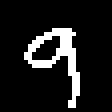

In [18]:
let
    index_to_look_at = 80; # which image to look at?
    img = Z[:,index_to_look_at] |> x-> reshape(x, number_of_rows, number_of_cols) |> transpose |> Matrix; # Magic? No just the majesty of Julia
    Gray.(img) # convert to a gray scale image, display
end

What does the entire $\mathbf{Z}$ matrix look like? 

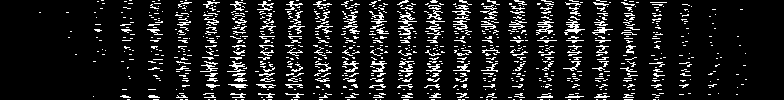

In [20]:
Gray.(transpose(Z)) # tranpose: T x d_{in}

__Build an SSN model instance__: We model an SSN using [the `MyLIFSpikingNeuralNetworkModel` type](src/Types.jl#L5). The [`MyLIFSpikingNeuralNetworkModel` type](src/Types.jl) implements the [Leaky Integrate-and-Fire (LIF) neuron model](https://www.nature.com/articles/s41598-017-07418-y), which is a simple and widely used model for spiking neurons. 

We construct this type [using a `build(...)` method](src/Factory.jl); we pass in the type of thing we want to build and the data required to build it. We get back a model (populated) model instance. We save the SSN model instance in the `ssnmodel::MyLIFSpikingNeuralNetworkModel` variable.

In [22]:
ssnmodel = let

    # build model -
    model = build(MyLIFSpikingNeuralNetworkModel, (
        Δt = Δt, # time step (ms)
        τ = τ, # time constant (ms)
        ν = ν, # firing threshold
        number_of_nodes = number_of_neurons, # number of neurons
        number_of_inputs = number_of_inputs, # number of inputs
    ));

    model;
end;

Not that we have a populated `ssnmodel::MyLIFSpikingNeuralNetworkModel` model, we can run the model forward in time and generate the spiking patterns for our system. We do this [using the `solve(...)` method](src/Compute.jl). 
* _Arguments_: We pass in the model instance, the input data array (images in the columns), and the length of spike pattern we want to generate (optional arguement with default `100 ms`), and the refractory period parameter $\Delta_{r}$, which has a default value of `3 ms`. The [`solve(...)` method](src/Compute.jl) returns a time vector `T::Array{Float64,1}`, the membrane voltage array `V::Array{Float64,2}` array and a spike pattern array `s::Array{Float64,2}`.
* _What does `T` represent_? The parameter `T` represents the length of time that we run the SNN; we feed a new image during each time step $t = 1,2,\dots{T}$. Physically, the time $T$ represents the length of time that we are recording the spike pattern of the LIF neurons, where we observe the system every $\Delta{t}$ ms.

Let's run the model:

In [24]:
(Tₐ,Vₐ,sₐ) = let

    # initialize -
    Δᵣ = 6; # TODO: Update the refactory period, and see what happens
    T = size(Z,2); # How many columns do we have (process one per time step)
    sₒ = zeros(Int, number_of_neurons); # initial conditions for the spikes (all 0)
    (T,V,s) = solve(ssnmodel, Z, T = T, Δᵣ = Δᵣ, sₒ = sₒ);

    (T,V,s) # return the time, voltage, and spikes
end;

__What gets generated from the SSN?__ Let's look at the spike pattern generated by the SSN model. The rows of the spike matrix `s::Array{Float64,2}` denote the input image index, while the columns denote the spike state for each neuron in the network. The values in the spike matrix are either `0` (no spike) or `1` (spike).

In [26]:
sₐ

100×16 Matrix{Float64}:
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  1.0  1.0  1.0  0.0  0.0  1.0
 0.0  0.0  1.0  1.0  0.0  1.0  0.0  0.0     1.0  0.0  0.0  0.0  1.0  1.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  1.0  1.0  1.0  0.0  0.0  1.0
 0.0  0.0  1.0  1.0  0.0  1.0  0.0  0.0     1.0  0.0  0.0  0.0  1.0  1.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

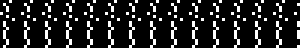

In [27]:
Gray.(transpose(sₐ)) # What is this saying?

### Discussion
1. What do the rows (and columns) of the transposed spike matrix `s::Array{Float64,2}` represent?
2. What happens if we change the refractory period parameter $\Delta_{r}$?

## Task 3: Let's build an S5 model to process the spikes
In this task, we'll build a simplified structured state space sequence (S5) model instance. We'll feed in the spike patterns from our SSN into the S5 model, and output a sequence of transformed digits by including a nonlinear output transformation.

First, let's build [an instance of the `MyS5Model` type](src/Types.jl#L5). The [`MyS5Model` type](src/Types.jl) is constructed using [a custom `build(...)` method](src/Factory.jl). In the [`build(...)` method](src/Factory.jl), we pass in the type we want to build, and the data required to build it. We get back a model (populated) model instance. 

Our build methods don't normally do much, but in this case, we construct all the system matrices, diagonalize them, and compute the required discrete system matrices. We save the S5 model instance in the `s5model::MyS5Model` variable.

In [30]:
s5model = let

    # initialize -
    number_of_hidden_states = 2^4; # number of hidden states
    number_of_inputs = number_of_neurons; # number of inputs
    number_of_outputs = 10; # number of outputs: the number of numbers we want to classify
    Δt = 2.0; # adjust for open-loop stability (which is curious)

    # build model -
    model = build(MyS5Model, (
        Δt = Δt, # time step (ms)
        number_of_hidden_states = number_of_hidden_states, # number of hidden states
        number_of_inputs = number_of_inputs, # number of inputs
        number_of_outputs = number_of_outputs, # the number of outputs
    ));

    model;
end;

__Solve the S5 model__: Now that we have a populated `s5model::MyS5Model` model, we can run the model forward in time and generate the output for our system. We do this [using the `solve(...)` method](src/Compute.jl).
* _Arguments_: We pass in the model instance, the input data array (spike patterns in the columns), and the time upper bound $[0,T]$. The [`solve(...)` method](src/Compute.jl) returns a time vector `T::Array{Float64,1}`, the hidden state array `H::Array{Float64,2}` array, the output array `Y::Array{Float64,2}` and the output spike pattern array `U::Array{Float64,2}` (which is the transpose of the spike pattern matrix `s::Array{Float64,2}` from the SSN model).

Run the S5 model:

In [32]:
(TS5,HS5,YS5, U) = let
    
    U = transpose(sₐ) |> Matrix; # formulate the input (transposed spike patterns)
    (TS5,HS5,YS5) = solve(s5model,U,100); # solve the S5 model -

    TS5, HS5, YS5, U # return the time, hidden states, output and the input
end;

What do we put into the S5 model?

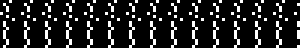

In [34]:
Gray.(U) # This is what feed into the model d_neurons x T

What do we get out of the S5 model?

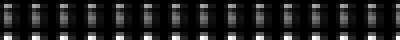

In [36]:
Gray.(transpose(abs.(YS5))) # This is what we get (d_{out} x T)

In [37]:
size(YS5)

(100, 10)

__What the S5 is saying to us__? The output of the S5 model is a matrix $\mathbf{Y}\in\mathbb{R}^{d_{out}\times{T}}$, where $d_{out}$ is the number of outputs in the S5 model (dictated by the application), and $T$ is the time length of the simulation (number of input images). 
* _What can the columns of the output matrix `Y::Array{Float64,2}` represent_? Depends. In this case, let's run each column through a $\texttt{softmax}$ function, and then take the index of the maximum value in each column. This gives us a vector of length $T$ that we can use to decode the output of the S5 model, i.e., the digit that the S5 model is trying to tell us.

Decode the output of the S5 model:

In [39]:
Nₐ = let
    Y = transpose(YS5) |> Matrix;
    (number_of_rows, number_of_cols) = size(Y);
    number_array = Array{Int64,1}(undef, number_of_cols); # numbers we are going to decode

    for i ∈ 1:number_of_cols
        number_array[i] = NNlib.softmax(abs.(Y[:,i])) |> x-> argmax(x) |> i -> i -1; # zero based
    end

    number_array
end

100-element Vector{Int64}:
 9
 9
 9
 9
 9
 0
 0
 9
 9
 9
 9
 9
 0
 ⋮
 9
 0
 0
 9
 9
 9
 9
 9
 0
 0
 9
 9

### Discussion
1. What do the rows of the output matrix `Y::Array{Float64,2}` represent?
2. Hmmm. Interesting. Let's brainstorm about what we could do with these models if we had more time (and could train them).

## What's coming up next time?
In lecture `L15c`, we'll look at [Graph Neural Networks (GNNs)](https://en.wikipedia.org/wiki/Graph_neural_network).
* __Graph Neural Networks (GNNs)__ are another type of neural network architecture specifically designed to operate on data structured as graphs, where entities (nodes) and their relationships (edges) are represented explicitly. 
* __How are GNNs different from traditional neural networks?__ Traditional neural networks typically operate on fixed-size, grid-like data structures (e.g., images, sequences), while GNNs can handle variable-sized graphs with complex connectivity patterns. This flexibility allows GNNs to model relationships and dependencies between entities more effectively, e.g., predicting user behavior in social networks by analyzing connections